In [1]:
# Instalação dos pacotes necessários para o ambiente Colab
%pip install langchain langchain-openai langchain-community faiss-cpu langgraph python-dotenv requests

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.3/84.3 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 86.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.6/23.6 MB 80.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.7/64.7 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 47.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 4.0 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.32.4
    Uninstalling requests-2.32.4:
      Successfully uninstalled requests-2.32.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests==2.32.4, but you have requests 2.32.5 which is incompatible.


In [2]:
import os
# Import para carregar variáveis do Colab Secrets
from google.colab import userdata
# Import da interface de chat da OpenAI via LangChain
from langchain_openai import ChatOpenAI


# 1. Carregar variáveis de ambiente do Colab Secrets
# O userdata.get busca a chave configurada no Colab Secrets
OPENAI_API_KEY = userdata.get("OPENAI_API_KEY")

# Verificação opcional de segurança (apenas para debug)
if OPENAI_API_KEY:
    print("✅ Chave de API carregada com sucesso do Colab Secrets.")
else:
    print("❌ Chave de API não encontrada. Verifique suas variáveis no Colab Secrets.")

# 2. Instanciar o modelo
# Aqui estamos usando o gpt-4o-mini, mas você pode alterar conforme necessidade
try:
    llm = ChatOpenAI(model="gpt-4o-mini", openai_api_key=OPENAI_API_KEY) # Passa a chave da API explicitamente

    # 3. Validar a chamada à LLM (Teste simples)
    print("Enviando teste para a OpenAI...")
    response = llm.invoke("Diga 'Ambiente configurado com sucesso' em uma frase curta.")

    print("-" * 30)
    print("RESPOSTA DO MODELO:")
    print(response.content)
    print("-" * 30)

except Exception as e:
    print(f"Ocorreu um erro ao conectar com a API: {e}")

✅ Chave de API carregada com sucesso do Colab Secrets.
Enviando teste para a OpenAI...
------------------------------
RESPOSTA DO MODELO:
Ambiente configurado com sucesso!
------------------------------


In [11]:
import os
import requests
from typing import List, Dict
from typing_extensions import TypedDict

# Importações do LangChain e componentes de IA
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_community.vectorstores import FAISS
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_core.documents import Document
from langchain_core.prompts import PromptTemplate
from langchain_core.runnables import RunnablePassthrough
from langchain_core.output_parsers import StrOutputParser
from langgraph.graph import StateGraph, END

# Configuração da Chave de API (Substitua pela sua chave ou use o Secrets do Colab)
# No vídeo ele usa load_dotenv(), aqui adaptamos para o Colab:
import getpass

In [5]:
import requests
# URL do livro Dom Casmurro no Project Gutenberg
url_livro = "https://www.gutenberg.org/files/55752/55752-0.txt"
nome_arquivo = "machado.txt"

# Download do arquivo se não existir
if not os.path.exists(nome_arquivo):
    print("Baixando o livro...")
    response = requests.get(url_livro)
    # Ajuste de encoding para português
    response.encoding = 'utf-8'
    with open(nome_arquivo, "w", encoding='utf-8') as f:
        f.write(response.text)
    print("Download concluído.")
else:
    print("Arquivo já existe.")

# Carregar o texto do arquivo
with open(nome_arquivo, "r", encoding='utf-8') as f:
    machado_text = f.read()

# Mostra os primeiros caracteres para confirmar
print(f"\nInício do texto:\n{machado_text[:500]}...")

Baixando o livro...
Download concluído.

Início do texto:
*** START OF THE PROJECT GUTENBERG EBOOK 55752 ***

DOM CASMURRO

POR

MACHADO DE ASSIS

DA ACADEMIA BRAZILEIRA

H. GARNIER, LIVREIRO-EDITOR

RUA MOREIRA CEZAR, 71

RIO DE JANEIRO

6, RUE DES SAINTS-PÈRES, 6

PARIZ




I

Do titulo.

Uma noite destas, vindo da cidade para o Engenho Novo, encontrei no
trem da Central um rapaz aqui do bairro, que eu conheço de vista e
de chapéo. Comprimentou-me, sentou-se ao pé de mim, falou da lua e
dos ministros, e acabou recitando-me versos. A viagem era curta,...


In [13]:

# Função para criar documentos a partir do texto bruto
def create_vector_store(text_content):
    # Configuração do Splitter (Chunking)
    # chunk_size: tamanho do pedaço
    # chunk_overlap: sobreposição para não perder contexto entre cortes
    splitter = RecursiveCharacterTextSplitter(
        chunk_size=1000,
        chunk_overlap=200
    )

    # Criação dos documentos (chunks)
    docs = splitter.create_documents([text_content])
    print(f"Texto dividido em {len(docs)} chunks.")

    # Criação do Vector Store (FAISS) usando os Embeddings da OpenAI
    vectorstore = FAISS.from_documents(docs, embeddings)
    return vectorstore

# Inicializar o objeto de embeddings da OpenAI
embeddings = OpenAIEmbeddings(openai_api_key=OPENAI_API_KEY)

# Criar a base vetorial
vectorstore = create_vector_store(machado_text)
retriever = vectorstore.as_retriever(search_kwargs={"k": 4}) # Traz os top 4 chunks

Texto dividido em 538 chunks.


In [14]:
# Definição do Estado do Grafo (Tipagem dos dados que fluem no grafo)
class RagState(TypedDict):
    query: str
    docs: List[Document]
    resposta_rag: str

# Nó 1: Recuperação (Retrieval)
def retrieve_node(state: RagState):
    print(f"--- RETRIEVING: {state['query']} ---")
    query = state["query"]
    # Busca os documentos relevantes usando o retriever criado anteriormente
    docs = retriever.invoke(query)
    return {"docs": docs}

# Função auxiliar para construir o prompt (Augmentation)
def build_prompt(query, docs):
    # Concatena o conteúdo dos documentos recuperados
    contexto = "\n\n".join([d.page_content for d in docs])

    template = """Responda em PT-BR de forma objetiva. Use APENAS o contexto abaixo.
    Se não houver contexto suficiente, diga que não há informação.

    Contexto:
    {context}

    Pergunta:
    {question}
    """

    prompt = PromptTemplate.from_template(template)
    return prompt.format(context=contexto, question=query)

# Nó 2: Geração (Generation)
def generate_rag_node(state: RagState):
    print("--- GENERATING ---")
    query = state["query"]
    docs = state["docs"]

    # Monta o prompt enriquecido
    prompt_final = build_prompt(query, docs)

    # Invoca a LLM
    response = llm.invoke(prompt_final)

    return {"resposta_rag": response.content}

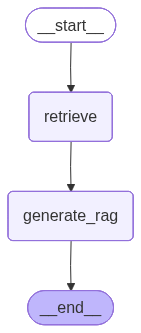

In [15]:
# Inicializa o grafo com o estado definido
workflow = StateGraph(RagState)

# Adiciona os nós
workflow.add_node("retrieve", retrieve_node)
workflow.add_node("generate_rag", generate_rag_node)

# Define a entrada do grafo (começa buscando documentos)
workflow.set_entry_point("retrieve")

# Define as arestas (o fluxo): Retrieve -> Generate -> Fim
workflow.add_edge("retrieve", "generate_rag")
workflow.add_edge("generate_rag", END)

# Compila o grafo para execução
app = workflow.compile()

# (Opcional) Visualizar o grafo se estiver no Jupyter
try:
    from IPython.display import Image, display
    display(Image(app.get_graph().draw_mermaid_png()))
except:
    pass

In [17]:
# Lista de perguntas para testar o RAG
perguntas = [
    "Quem é Capitu em Dom Casmurro e como ela é descrita?",
    "Qual a relação entre Bentinho e Escobar?",
    "Como o narrador apresenta suas memórias?",
    "Capitu traiu Bentinho? Sim ou Não"
]

print("=== INICIANDO EXECUÇÃO DO RAG ===\n")

for p in perguntas:
    print(f"Pergunta: {p}")

    # Invoca o grafo passando a query inicial
    resultado = app.invoke({"query": p})

    print(f"Resposta RAG: {resultado['resposta_rag']}")
    print("-" * 50)

    # (Opcional) Mostrar as fontes usadas
    # print("Fontes usadas:")
    # for doc in resultado['docs']:
    #     print(f"- {doc.page_content[:100]}...")
    print("\n")

=== INICIANDO EXECUÇÃO DO RAG ===

Pergunta: Quem é Capitu em Dom Casmurro e como ela é descrita?
--- RETRIEVING: Quem é Capitu em Dom Casmurro e como ela é descrita? ---
--- GENERATING ---
Resposta RAG: Capitu é uma das personagens principais de "Dom Casmurro", escrita por Machado de Assis. Ela é descrita como uma figura encantadora e central na vida do narrador, Bentinho. Sua presença é comparada a elementos da natureza, sendo considerada "a flôr da casa", "o sol das manhãs" e "a lua das noites". Capitu é vista por Bentinho e sua mãe como uma pessoa cheia de afeto e intimidade, estabelecendo um vínculo forte com ambos. Ela é caracterizada pela sua atenção, curiosidade e particularidade, sendo descrita como "mais mulher do que eu era homem". Essa descrição enfatiza sua singularidade e complexidade no contexto da narrativa.
--------------------------------------------------


Pergunta: Qual a relação entre Bentinho e Escobar?
--- RETRIEVING: Qual a relação entre Bentinho e Escobar? ---